#**Machine Learning Lab 1 Part 2: CIFAR-10 classification problem**

In this notebook, we try to find the classifier which best fits the CIFAR-10 dataset. First, the dataset is loaded and reduced to a more manageable size. First, we conducted some initial experiments with 20% of the dataset in order to have an intuition about which group of models perform better and where are the bottlenecks in terms of computation time. After the initial search was conducted, we extended the dataset to 35% to try and find a model which offers the best perfomance among the candidates with a good tradeoff concerning computation times. The following classifiers are tested:

*   Logistic regression
*   Ridge classifier
*   KNN
*   SVM
*   Voting classifier

All the models were trained using k-fold cross-validation to reduce overfitting along with hyperparameter search in order to find the best combination of parameters for each classifier from a set of pre-defined values using GridSearchCV (grid). However, as this function is especially demanding for the SVM classifier, the search was divided in two parts: an initial, more restricted search to find the best kernel, and a second search to find the best parameters for the chosen kernel.

The dataset is pre-processed using GIST descriptors, PCA and standard scaling. Some experiments were carried out without PCA -only GIST- in order to assess the impact of PCA during training and validation.

Training and validation results are presented and analyzed in the respective section below, as well as the results of final predictions over the test set with the selected model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import preprocessing
from keras.datasets import cifar10
import cv2

In [ ]:
# This class implements the extraction of a GIST descriptor from an image.
# The GIST descriptor was originally proposed in https://people.csail.mit.edu/torralba/code/spatialenvelope/
# This code was taken from https://github.com/imoken1122/GIST-feature-extractor, on september 2020

import numpy as np
import numpy.matlib as nm
import numpy.fft as f
from PIL import Image

class GIST():
    def __init__(self,param):
        self.param = param

    def _createGabor(self,orr,n):

        gabor_param = []
        Nscalse = len(orr)
        Nfilters = sum(orr)
        if len(n) == 1:
            n = [n[0],n[0]]
        for i in range(Nscalse):
            for j in range(orr[i]):
                gabor_param.append([.35,.3/(1.85**(i)),16*orr[i]**2/32**2, np.pi/(orr[i])*(j)])
        gabor_param = np.array(gabor_param)
        fx, fy = np.meshgrid(np.arange(-n[1]/2,n[1]/2-1 + 1), np.arange(-n[0]/2, n[0]/2-1 + 1))
        fr = f.fftshift(np.sqrt(fx**2+fy**2))
        t = f.fftshift(np.angle(fx+ 1j*fy))

        G = np.zeros([n[0],n[1],Nfilters])
        for i in range(Nfilters):
            tr = t + gabor_param[i,3]
            tr+= 2*np.pi*(tr < -np.pi) - 2 * np.pi*(tr>np.pi)
            G[:,:,i] = np.exp(-10*gabor_param[i,0]*(fr/n[1]/gabor_param[i,1]-1)**2-2*gabor_param[i,2]*np.pi*tr**2)

        return G

    def _more_config(self,img):

        self.param["imageSize"] = [img.shape[0], img.shape[1]]
        self.param["G"] = self._createGabor(self.param["orientationsPerScale"],np.array(self.param["imageSize"])+2*self.param["boundaryExtension"])


    def _preprocess(self,img):
        M = self.param["imageSize"]
        if len(M) == 1:
            M = [M, M]
        scale = np.max([M[0]/img.shape[0], M[1]/img.shape[1]])
        newsize = list(map(int,np.round(np.array([img.shape[1],img.shape[0]]) * scale)))
        img = np.array(Image.fromarray(img).resize(newsize, Image.BILINEAR))
        #img = imresize(img,newsize,'bilinear')

        nr,nc = img.shape
        sr = (nr-M[0])/2
        sc = (nc-M[1])/2

        img = img[int(sr):int(sr+M[0])+ 1,int(sc):int(sc+M[1])+1]
        img = img- np.min(img)
        if np.sum(img) != 0:
            img = 255*(img/np.max(img))

        return img


    def _prefilt(self,img):

        w = 5
        fc=self.param["fc_prefilt"]
        s1 = fc/np.sqrt(np.log(2))
        img=np.log(img +1 )
        img = np.pad(img,[w,w],"symmetric")

        sn,sm = img.shape
        n = np.max([sn,sm])
        n += n%2

        if sn == sm:
            img = np.pad(img,[0,int(n-sn)],"symmetric")
        else:
            img = np.pad(img,[0,int(n-sn)], "symmetric")[:,:sm]

        fx,fy = np.meshgrid(np.arange(-n/2,n/2-1 + 1),np.arange(-n/2,n/2-1 + 1))
        gf = f.fftshift((np.exp(-(fx**2+fy**2)/(s1**2))))
        gf = nm.repmat(gf,1,1)
        output = img - np.real(f.ifft2(f.fft2(img)*gf))

        localstd = nm.repmat(np.sqrt(abs(f.ifft2(f.fft2(output**2)*gf))), 1 ,1 )
        output = output/(0.2+localstd)
        output = output[w:sn-w, w:sm-w]
        return output

    def _gistGabor(self,img):

        w = self.param["numberBlocks"]
        G = self.param["G"]
        be = self.param["boundaryExtension"]
        ny,nx,Nfilters = G.shape
        W = w[0] * w[1]
        N = 1
        g = np.zeros((W*Nfilters, N))
        img = np.pad(img,[be,be],"symmetric")
        img = f.fft2(img)

        k = 0
        for n in range(Nfilters):
            ig = abs(f.ifft2(img*nm.repmat(G[:,:,n],1,1)))
            ig = ig[be:ny-be,be:nx-be]
            v = self._downN(ig,w)
            g[k:k+W,0] = v.reshape([W,N],order = "F").flatten()
            k += W
        return np.array(g)

    def _downN(self,x,N):
        nx = list(map(int,np.floor(np.linspace(0,x.shape[0],N[0]+1))))
        ny = list(map(int,np.floor(np.linspace(0,x.shape[1],N[1]+1))))
        y  = np.zeros((N[0],N[1]))
        for xx in range(N[0]):
            for yy in range(N[1]):
                a = x[nx[xx]:nx[xx+1], ny[yy]:ny[yy+1]]
                v = np.mean(np.mean(a,0))
                y[xx,yy]=v
        return y

    def _gist_extract(self,img):

        self._more_config(img)

        img = self._preprocess(img)

        output = self._prefilt(img)

        gist = self._gistGabor(output)

        return gist.flatten()

In this section, we load the dataset and extract the GIST descriptor of one image example. As it can be seen, the images are 32x32x3, and the GIST descriptor brings the size down to 256. The image is plotted along with the label, which in this case is (9) corresponding to class "truck". After this, we extract the GIST descriptor of every image in the reduced dataset, which usually takes a while even using this smaller version.

Training set size: (50000, 32, 32, 3)
Labels size: (50000, 1)
Reduced training set size: (17500, 32, 32, 3)
Reduced training labels size: (17500, 1)
Reduced test set size: (1750, 32, 32, 3)
Reduced test labels size: (1750, 1)


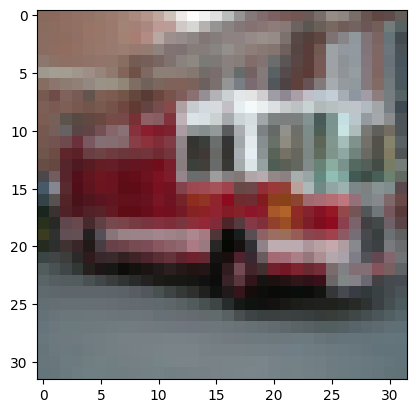

GIST descriptor: (256,)
Label: [9]


In [ ]:
# get training data
(im_train_and_val, y_train_and_val), (im_test, y_test) = cifar10.load_data()
print('Training set size: {}'.format(im_train_and_val.shape))

print('Labels size: {}'.format(y_train_and_val.shape))

# Reduce size
im_train_and_val, im_train_and_val, y_train_and_val, y_train_and_val = train_test_split(im_train_and_val, y_train_and_val, test_size = 0.35, random_state=5)
im_test, im_test, y_test, y_test = train_test_split(im_test, y_test, test_size = 0.175, random_state = 5)

print('Reduced training set size: {}'.format(im_train_and_val.shape))
print('Reduced training labels size: {}'.format(y_train_and_val.shape))

print('Reduced test set size: {}'.format(im_test.shape))
print('Reduced test labels size: {}'.format(y_test.shape))

# Parameters needed for the GIST descriptor
param = {
        "orientationsPerScale":np.array([8,8]),
         "numberBlocks":[4,4],
        "fc_prefilt":10,
        "boundaryExtension":32
}

# Extract the GIST descriptor of image 134
mygist = GIST(param)
imggray = cv2.cvtColor(im_train_and_val[134,:,:,:], cv2.COLOR_BGR2GRAY)
plt.imshow(im_train_and_val[134,:,:,:])
plt.show()
gistdesc = np.squeeze(mygist._gist_extract(imggray))
print('GIST descriptor: {}'.format(gistdesc.shape))
print('Label:', y_train_and_val[134,:])

In [ ]:
# Parameters needed for the GIST descriptor
param = {
        "orientationsPerScale":np.array([8,8]),
         "numberBlocks":[4,4],
        "fc_prefilt":10,
        "boundaryExtension":32
}

# Extract GIST descriptor of every image in the dataset
mygist = GIST(param)

n_train_and_val = im_train_and_val.shape[0]
n_test = im_test.shape[0]
x_train_and_val_gist = np.zeros((n_train_and_val,256))
x_test_gist = np.zeros((n_test,256))

for i in range(n_train_and_val):
  imggray = cv2.cvtColor(im_train_and_val[i,:,:,:], cv2.COLOR_BGR2GRAY)
  x_train_and_val_gist[i,:] = np.squeeze(mygist._gist_extract(imggray))
  print('Converting training set, image ', i, ' out of ', n_train_and_val)

for i in range(n_test):
  imggray = cv2.cvtColor(im_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
  x_test_gist[i,:] = np.squeeze(mygist._gist_extract(imggray))
  print('Converting test set, image ', i, ' out of ', n_test)

Se han truncado las últimas 5000 líneas del flujo de salida.
Converting training set, image  14250  out of  17500
Converting training set, image  14251  out of  17500
Converting training set, image  14252  out of  17500
Converting training set, image  14253  out of  17500
Converting training set, image  14254  out of  17500
Converting training set, image  14255  out of  17500
Converting training set, image  14256  out of  17500
Converting training set, image  14257  out of  17500
Converting training set, image  14258  out of  17500
Converting training set, image  14259  out of  17500
Converting training set, image  14260  out of  17500
Converting training set, image  14261  out of  17500
Converting training set, image  14262  out of  17500
Converting training set, image  14263  out of  17500
Converting training set, image  14264  out of  17500
Converting training set, image  14265  out of  17500
Converting training set, image  14266  out of  17500
Converting training set, image  14267 

# Perform PCA

In [ ]:
# Initialize PCA with desired number of components (e.g., n_components=100)
pca = PCA(n_components=50)

# Fit PCA on training data and transform both training and validation data
x_train_and_val_gist_pca = pca.fit_transform(x_train_and_val_gist)
x_test_gist_pca = pca.transform(x_test_gist)

# Perform Data Scaling

## PCA version

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#Scale version with PCA
scaler.fit(x_train_and_val_gist_pca)
x_train_and_val_gist_pca_scaled = scaler.transform(x_train_and_val_gist_pca)
x_test_gist_pca_scaled = scaler.transform(x_test_gist_pca)

## No PCA version

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#Scale version without PCA
scaler.fit(x_train_and_val_gist)
x_train_and_val_gist_scaled = scaler.transform(x_train_and_val_gist)
x_test_gist_scaled = scaler.transform(x_test_gist)

#To use same naming in following blocks
x_train_and_val_gist_pca_scaled = x_train_and_val_gist_scaled
x_test_gist_pca_scaled = x_test_gist_scaled


## **SPLIT DATA**

In [ ]:
# Validation data set

x_train, x_val, y_train, y_val = train_test_split(x_train_and_val_gist_pca_scaled, y_train_and_val, test_size = 0.1, random_state=5)

#Change labels from column vector to 1D array
y_train_and_val = np.ravel(y_train_and_val)

print('Training Data size: ', x_train.shape)
print('Training output size: ', y_train.shape)
print('Validation Data size: ', x_val.shape)
print('Validation Output size: ', y_val.shape)
print('Test Data size: ', x_test_gist.shape)
print('Test Output size: ', y_test.shape)

Training Data size:  (15750, 50)
Training output size:  (15750, 1)
Validation Data size:  (1750, 50)
Validation Output size:  (1750, 1)
Test Data size:  (1750, 256)
Test Output size:  (1750, 1)


# **Training and validation**

### Logistic regression with cross-validation

In [ ]:
from sklearn.linear_model import LogisticRegression

#Change labels from column vector to 1D array
y_train_and_val = np.ravel(y_train_and_val)

# Create a logistic regression model
logistic_model = LogisticRegression(max_iter = 1000)

# Cross validation w/ linear regression
cv_scores_lr = cross_validate(logistic_model, x_train_and_val_gist_pca_scaled, y_train_and_val, cv=10, scoring = ('accuracy', 'precision_macro', 'recall_macro'), verbose = 3)

print('Accuracy, k-fold cross validation, logistic regression: {}'.format(np.mean(cv_scores_lr['test_accuracy'])))
print('Scores for all folds: {}\n'.format(cv_scores_lr['test_accuracy']))
print('Precision, k-fold cross validation, logistic regression: {}'.format(np.mean(cv_scores_lr['test_precision_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_lr['test_precision_macro']))
print('Recall, k-fold cross validation, logistic regression: {}'.format(np.mean(cv_scores_lr['test_recall_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_lr['test_recall_macro']))

[CV] END  accuracy: (test=0.555) precision_macro: (test=0.551) recall_macro: (test=0.556) total time=   0.2s
[CV] END  accuracy: (test=0.559) precision_macro: (test=0.555) recall_macro: (test=0.559) total time=   0.3s
[CV] END  accuracy: (test=0.557) precision_macro: (test=0.553) recall_macro: (test=0.557) total time=   0.3s
[CV] END  accuracy: (test=0.551) precision_macro: (test=0.548) recall_macro: (test=0.551) total time=   0.3s
[CV] END  accuracy: (test=0.541) precision_macro: (test=0.537) recall_macro: (test=0.542) total time=   0.4s
[CV] END  accuracy: (test=0.557) precision_macro: (test=0.556) recall_macro: (test=0.558) total time=   0.5s
[CV] END  accuracy: (test=0.561) precision_macro: (test=0.557) recall_macro: (test=0.562) total time=   1.0s
[CV] END  accuracy: (test=0.546) precision_macro: (test=0.543) recall_macro: (test=0.546) total time=   1.1s
[CV] END  accuracy: (test=0.562) precision_macro: (test=0.555) recall_macro: (test=0.562) total time=   0.9s
[CV] END  accuracy:

### KNN with hyperparameter search + cross-validation

In [ ]:
from sklearn.model_selection import GridSearchCV


# Tune hyperparameters
nn_model = KNeighborsClassifier()
parameters_knn = {'n_neighbors':[1, 3, 5, 10, 15, 20, 25, 30]}
knn_hyp = GridSearchCV(nn_model, parameters_knn)
knn_result = knn_hyp.fit(x_train_and_val_gist_pca_scaled, y_train_and_val)
cv_scores_knn = cross_validate(knn_result.best_estimator_, x_train_and_val_gist_pca_scaled, y_train_and_val, cv=10, scoring = ('accuracy', 'precision_macro', 'recall_macro'), verbose = 3)
print('Accuracy, k-fold cross validation, knn: {}'.format(np.mean(cv_scores_knn['test_accuracy'])))
print('Scores for all folds: {}'.format(cv_scores_knn['test_accuracy']))
print('Precision, k-fold cross validation, knn: {}'.format(np.mean(cv_scores_knn['test_precision_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_knn['test_precision_macro']))
print('Recall, k-fold cross validation, knn: {}'.format(np.mean(cv_scores_knn['test_recall_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_knn['test_recall_macro']))
print('Best parameters set found on development set: {}\n'.format(knn_result.best_params_))

[CV] END  accuracy: (test=0.505) precision_macro: (test=0.578) recall_macro: (test=0.506) total time=   0.3s
[CV] END  accuracy: (test=0.512) precision_macro: (test=0.590) recall_macro: (test=0.513) total time=   0.3s
[CV] END  accuracy: (test=0.509) precision_macro: (test=0.586) recall_macro: (test=0.510) total time=   0.3s
[CV] END  accuracy: (test=0.509) precision_macro: (test=0.580) recall_macro: (test=0.510) total time=   0.3s
[CV] END  accuracy: (test=0.487) precision_macro: (test=0.563) recall_macro: (test=0.488) total time=   0.3s
[CV] END  accuracy: (test=0.502) precision_macro: (test=0.575) recall_macro: (test=0.503) total time=   0.3s
[CV] END  accuracy: (test=0.515) precision_macro: (test=0.607) recall_macro: (test=0.517) total time=   0.3s
[CV] END  accuracy: (test=0.490) precision_macro: (test=0.567) recall_macro: (test=0.491) total time=   0.3s
[CV] END  accuracy: (test=0.502) precision_macro: (test=0.573) recall_macro: (test=0.503) total time=   0.3s
[CV] END  accuracy:

### Ridge classifier with hyperparameter search + cross-validation

In [ ]:
ridge_model = RidgeClassifier()
parameters_rc = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
rc_hyp = GridSearchCV(ridge_model, parameters_rc)
rc_result = rc_hyp.fit(x_train_and_val_gist_pca_scaled, y_train_and_val)
cv_scores_rc = cross_validate(rc_result.best_estimator_, x_train_and_val_gist_pca_scaled, y_train_and_val, cv=10, scoring = ('accuracy', 'precision_macro', 'recall_macro'), verbose = 3)

print('Accuracy, k-fold cross validation, ridge classifier: {}'.format(np.mean(cv_scores_rc['test_accuracy'])))
print('Scores for all folds: {}'.format(cv_scores_rc['test_accuracy']))
print('Precision, k-fold cross validation, ridge classifier: {}'.format(np.mean(cv_scores_rc['test_precision_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_rc['test_precision_macro']))
print('Recall, k-fold cross validation, ridge classifier: {}'.format(np.mean(cv_scores_rc['test_recall_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_rc['test_recall_macro']))
print('Best parameters set found on development set: {}\n'.format(rc_result.best_params_))

[CV] END  accuracy: (test=0.513) precision_macro: (test=0.510) recall_macro: (test=0.514) total time=   0.0s
[CV] END  accuracy: (test=0.545) precision_macro: (test=0.537) recall_macro: (test=0.545) total time=   0.0s
[CV] END  accuracy: (test=0.538) precision_macro: (test=0.532) recall_macro: (test=0.538) total time=   0.0s
[CV] END  accuracy: (test=0.521) precision_macro: (test=0.515) recall_macro: (test=0.521) total time=   0.0s
[CV] END  accuracy: (test=0.517) precision_macro: (test=0.509) recall_macro: (test=0.517) total time=   0.0s
[CV] END  accuracy: (test=0.520) precision_macro: (test=0.518) recall_macro: (test=0.520) total time=   0.0s
[CV] END  accuracy: (test=0.517) precision_macro: (test=0.510) recall_macro: (test=0.518) total time=   0.0s
[CV] END  accuracy: (test=0.529) precision_macro: (test=0.526) recall_macro: (test=0.529) total time=   0.0s
[CV] END  accuracy: (test=0.534) precision_macro: (test=0.530) recall_macro: (test=0.534) total time=   0.0s
[CV] END  accuracy:

### SVM with hyperparameter search + cross-validation

In [ ]:
svm = SVC()
parameters_svm = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.01, 0.1, 1, 2, 4]}
svm_hyp = GridSearchCV(svm, parameters_svm, verbose = 3)
svm_result = svm_hyp.fit(x_train_and_val_gist_pca_scaled, y_train_and_val)
cv_scores_svm = cross_validate(svm_result.best_estimator_, x_train_and_val_gist_pca_scaled, y_train_and_val, cv=10, scoring = ('accuracy', 'precision_macro', 'recall_macro'), verbose = 3)
print('Accuracy, k-fold cross validation, SVM: {}'.format(np.mean(cv_scores_svm['test_accuracy'])))
print('Scores for all folds: {}'.format(cv_scores_svm['test_accuracy']))
print('Precision, k-fold cross validation, SVM: {}'.format(np.mean(cv_scores_svm['test_precision_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_svm['test_precision_macro']))
print('Recall, k-fold cross validation, SVM: {}'.format(np.mean(cv_scores_svm['test_recall_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_svm['test_recall_macro']))
print('Best parameters set found on development set: {}\n'.format(svm_result.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.569 total time=  25.3s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.573 total time=  26.1s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.574 total time=  26.7s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.575 total time=  26.7s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.572 total time=  25.6s
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.201 total time=  56.9s
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.219 total time=  56.5s
[CV 3/5] END ...............C=0.01, kernel=poly;, score=0.217 total time=  56.3s
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.223 total time=  57.3s
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.218 total time= 1.0min
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.317 total time= 1.2min
[CV 2/5] END ................C=0.01, kernel=rbf

### SVM hyperparameter search with best performing kernel 'rbf'

In [ ]:
svm = SVC(kernel = 'rbf')
parameters_svm = {'C':[0.01, 0.1, 1, 2, 4, 10, 15, 20, 25]}
svm_hyp = GridSearchCV(svm, parameters_svm, verbose = 3)
svm_result = svm_hyp.fit(x_train_and_val_gist_pca_scaled, y_train_and_val)
cv_scores_svm = cross_validate(svm_result.best_estimator_, x_train_and_val_gist_pca_scaled, y_train_and_val, cv=10, scoring = ('accuracy', 'precision_macro', 'recall_macro'), verbose = 3)
print('Accuracy, k-fold cross validation, SVM: {}'.format(np.mean(cv_scores_svm['test_accuracy'])))
print('Scores for all folds: {}'.format(cv_scores_svm['test_accuracy']))
print('Precision, k-fold cross validation, SVM: {}'.format(np.mean(cv_scores_svm['test_precision_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_svm['test_precision_macro']))
print('Recall, k-fold cross validation, SVM: {}'.format(np.mean(cv_scores_svm['test_recall_macro'])))
print('Scores for all folds: {}\n'.format(cv_scores_svm['test_recall_macro']))
print('Best parameters set found on development set: {}\n'.format(svm_result.best_params_))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ............................C=0.01;, score=0.134 total time=  34.9s
[CV 2/5] END ............................C=0.01;, score=0.138 total time=  36.7s
[CV 3/5] END ............................C=0.01;, score=0.141 total time=  30.5s
[CV 4/5] END ............................C=0.01;, score=0.141 total time=  31.7s
[CV 5/5] END ............................C=0.01;, score=0.135 total time=  31.5s
[CV 1/5] END .............................C=0.1;, score=0.575 total time=  22.8s
[CV 2/5] END .............................C=0.1;, score=0.576 total time=  23.0s
[CV 3/5] END .............................C=0.1;, score=0.574 total time=  23.9s
[CV 4/5] END .............................C=0.1;, score=0.575 total time=  24.0s
[CV 5/5] END .............................C=0.1;, score=0.585 total time=  21.9s
[CV 1/5] END ...............................C=1;, score=0.633 total time=  17.8s
[CV 2/5] END ...............................C=1;,

### Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('lr',logistic_model), ('svm',svm_result.best_estimator_)], voting='hard')
cv_scores_voting_clf = cross_val_score(voting_clf, x_train_and_val_gist_pca_scaled, y_train_and_val, cv=10, verbose = 3)
print('Accuracy, k-fold cross validation on test data, voting classifier: {}'.format(np.mean(cv_scores_voting_clf)))
print('Scores for all folds: {}'.format(cv_scores_voting_clf))

[CV] END ................................ score: (test=0.603) total time=  19.4s
[CV] END ................................ score: (test=0.595) total time=  20.4s
[CV] END ................................ score: (test=0.601) total time=  19.3s
[CV] END ................................ score: (test=0.599) total time=  21.3s
[CV] END ................................ score: (test=0.595) total time=  20.9s
[CV] END ................................ score: (test=0.605) total time=  20.5s
[CV] END ................................ score: (test=0.611) total time=  20.3s
[CV] END ................................ score: (test=0.599) total time=  19.8s
[CV] END ................................ score: (test=0.607) total time=  20.0s
[CV] END ................................ score: (test=0.613) total time=  20.4s
Accuracy, k-fold cross validation on test data, voting classifier: 0.6029142857142857
Scores for all folds: [0.60285714 0.59542857 0.60114286 0.59942857 0.59542857 0.60457143
 0.61085714 0.5

## **Training and validation results**

## Initial training and validation stage, 20% of the dataset.

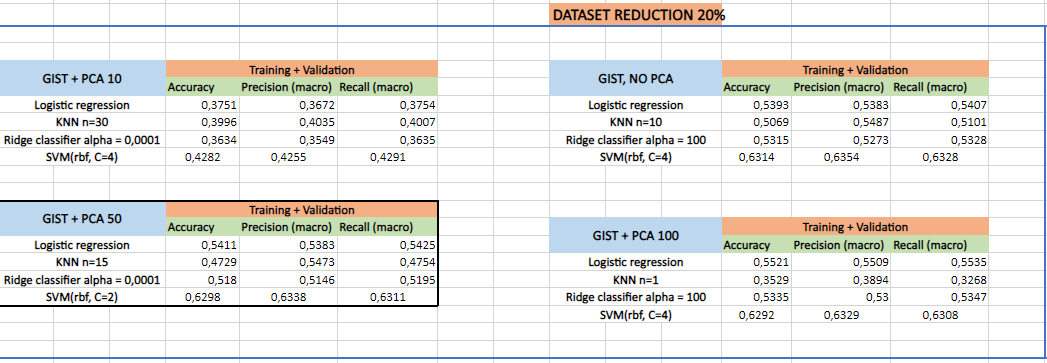

## Definitive training and validation stage. Selected model highlighted in green.

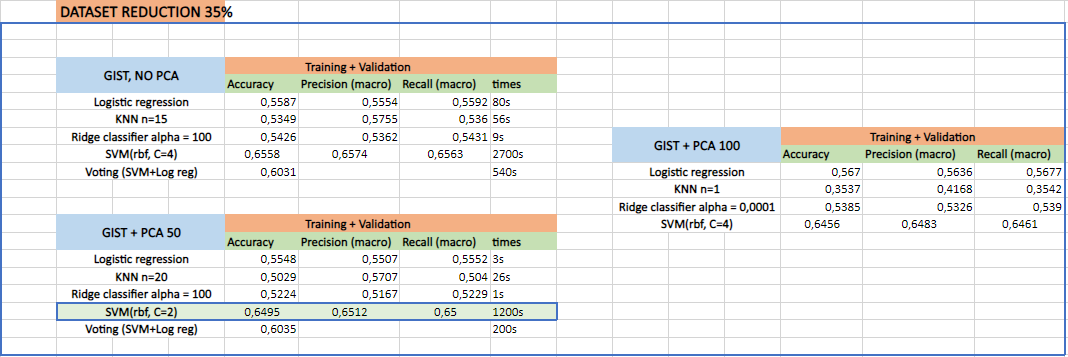

After the training and validation stage, a set of conclusions can be extracted from the different set of models that were trained and the pre-processing methods:



1.   The computational overhead of using just GIST without PCA is evident in the execution times which go to > 90 minutes particularly for the SVM models. In SVM, the execution times associated with the linear kernel scale exponentially with higher values of C and higher dimensionality of the feature vector, becoming unmanageable when C > 1 and PCA is not conducted.
2.   PCA was tested with n=10, n=25, n=50, n=100 dimensions. It was found that for values below 50, while computation was much faster, the performance was way poorer than the version without PCA. However, from 50 onwards, the results were equivalent to the version without PCA while taking around half of the time. On the other hand, values above 50 increase computation times with little to no impact in performance, so we settled with n=50.
3.   As a result of the initial hyperparameter search, SVM seems to perform the best followed closely by logistic regression and the ridge classifier, with KNN falling behind.

4. As it was stated before, the hyperparameter search performed by GridSearchCV has a significant computational overhead when training all variations of SVM models. The initial, more widespread search, led us to believe that SVM with RBF kernel is the best option moving on. From this, we conduct another more narrow search to find the best value of 'C' for the RBF kernel.



# Test

In this final section, we present the selected model with the test set and evaluate its perfomance making predicitons on unseen data. In this case, the model which offers the best tradeoff between performance and computation time is the SVM classifier with a RBF kernel and C=2, trained on data that has been pre-processed with GIST feature extraction, PCA=50 and standard scaling.

As it can be seen in the results, the model presents an accuracy of 65% which is quite acceptable for a machine learning algorithm trained on this dataset. However, the point can be made that this is a more sofisticated, non-linear version of SVM which is substantially more demanding than most basic classifiers. In fact, none of the other classifiers that were tested were able to make it past ~55% accuracy in training and validation.

In the confusion matrix below, it can be seen how the most common mistakes are made when differentiating classes 3 and 5, which correspond to 'cats' and 'dogs'. There are a bunch of mistakes too when classifying classes 0 and 8 'airplanes' and 'ships'. It can be understood how the classifier has trouble making a difference because we have two kind of similar animals and two large vehicles which fairly similar shapes and colors.

Accuracy in the test set, SVM: 0.6474285714285715


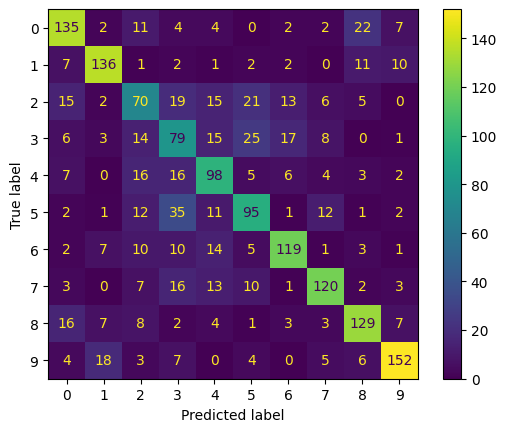

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Evaluate on the test set
acc_svm_test = svm_result.best_estimator_.score(x_test_gist_pca_scaled, y_test)
print('Accuracy in the test set, SVM: {}'.format(acc_svm_test))
ConfusionMatrixDisplay.from_estimator(svm_result.best_estimator_, x_test_gist_pca_scaled, y_test)
plt.show()  # doctest: +SKIP